In [25]:
import pandas as pd
import os
from tsfresh.feature_selection.significance_tests import target_binary_feature_real_test

In [16]:
y = pd.read_hdf('data/features/achat_y.h5')
y_bin = y.astype('category')
y_bin = pd.get_dummies(y_bin)

In [19]:
X_0 = pd.read_hdf('data/features/achat_0_eff.h5')

In [23]:
X_0.head()

variable,0__abs_energy,0__absolute_sum_of_changes,"0__agg_autocorrelation__f_agg_""mean""__maxlag_40","0__agg_autocorrelation__f_agg_""median""__maxlag_40","0__agg_autocorrelation__f_agg_""var""__maxlag_40","0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","0__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,0__symmetry_looking__r_0.9,0__symmetry_looking__r_0.9500000000000001,0__time_reversal_asymmetry_statistic__lag_1,0__time_reversal_asymmetry_statistic__lag_2,0__time_reversal_asymmetry_statistic__lag_3,0__value_count__value_-1,0__value_count__value_0,0__value_count__value_1,0__variance,0__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,1.384450e+08,1379.563259,0.995253,0.995535,9.159081e-06,-83.026032,0.248218,0.216546,0.034559,-79.649571,...,1.0,1.0,4580.145679,9185.218616,13815.077072,0.0,0.0,0.0,22705.329724,1.0
1,1.188296e+08,1529.668570,0.994483,0.994727,1.163661e-05,14.616850,-0.155239,-0.124645,0.032436,20.247239,...,1.0,1.0,-3951.511705,-7886.736899,-11805.520755,0.0,0.0,0.0,19235.532049,1.0
2,8.371111e+07,1113.226103,1.000396,1.000464,5.500405e-08,100.722344,-0.417589,-0.282581,0.025144,104.856623,...,1.0,1.0,-292.924561,-589.139589,-888.670425,0.0,0.0,0.0,13720.872397,1.0
3,2.557003e+07,747.692053,0.997285,0.997609,3.780315e-06,-23.796940,0.270493,0.101704,0.014802,-20.997968,...,1.0,1.0,239.980172,478.655083,716.027845,0.0,0.0,0.0,4224.427576,1.0
4,1.733206e+07,740.209275,1.000360,1.000579,4.043709e-07,-60.117920,0.593364,0.183051,0.010155,-57.253553,...,1.0,1.0,6.744334,13.921317,21.544288,0.0,0.0,0.0,2854.464180,1.0


In [97]:
X_0_filt = pd.DataFrame()
for feature in X_0:
    p = []
    try:
        p.append(target_binary_feature_real_test(X_0[feature],y_bin[0],'mann'))
        p.append(target_binary_feature_real_test(X_0[feature],y_bin[1],'mann'))
        p.append(target_binary_feature_real_test(X_0[feature],y_bin[2],'mann'))
    except ValueError:
        p.append(1000)
    
    if all(x <= 0.05 for x in p):
        X_0_filt = pd.concat([X_0_filt, X_0[feature]], axis=1)

In [99]:
X_0_filt.head()

,0__abs_energy,0__absolute_sum_of_changes,"0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","0__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","0__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","0__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","0__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","0__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","0__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","0__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""",...,0__quantile__q_0.7,0__quantile__q_0.8,0__quantile__q_0.9,0__range_count__max_1__min_-1,0__spkt_welch_density__coeff_2,0__spkt_welch_density__coeff_5,0__spkt_welch_density__coeff_8,0__standard_deviation,0__sum_values,0__variance
0,1.384450e+08,1379.563259,0.034559,0.393180,0.012191,0.034469,0.387842,0.012177,0.034378,0.382112,...,43.831641,144.812374,238.922411,31.0,1491.749034,3.254776,0.182798,150.682878,-115230.756336,22705.329724
1,1.188296e+08,1529.668570,0.032436,0.369146,0.011441,0.032349,0.363963,0.011428,0.032261,0.358404,...,44.909805,125.482226,206.305793,23.0,1384.861655,3.243780,0.183016,138.692221,-143173.212913,19235.532049
2,8.371111e+07,1113.226103,0.025144,0.283007,0.008882,0.025140,0.282866,0.008881,0.025135,0.282466,...,111.228936,135.804621,175.827868,18.0,797.139595,1.791145,0.100834,117.136128,91630.595379,13720.872397
3,2.557003e+07,747.692053,0.014802,0.168095,0.005223,0.014770,0.166157,0.005218,0.014736,0.164047,...,39.830168,74.695071,102.289649,25.0,408.324396,0.846638,0.047391,64.995597,36616.964715,4224.427576
4,1.733206e+07,740.209275,0.010155,0.114239,0.003587,0.010152,0.114143,0.003586,0.010149,0.113857,...,33.002022,46.493591,66.940971,46.0,363.783312,0.707188,0.039389,53.427186,-35094.897172,2854.464180


In [131]:
# try to distinguish between just 1 and 2
# X_0_drug = X_0.iloc[150]
df_drug = X_0.join(y)
df_drug = df_drug[df_drug['y'] != 0]
df_drug['y'] = df_drug['y'].astype('category')
df_drug['y'] = pd.get_dummies(df_drug['y'])

X_0_filt2 = pd.DataFrame()
for feature in df_drug:
    try:
        p = target_binary_feature_real_test(df_drug[feature],df_drug['y'],'mann')
    except ValueError:
        p = 255
    
    if p <= 0.00001:
        X_0_filt2 = pd.concat([X_0_filt2, df_drug[feature]], axis=1)

In [160]:
X_0_filt2

,"0__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",0__ar_coefficient__k_10__coeff_1,0__ar_coefficient__k_10__coeff_2,0__ar_coefficient__k_10__coeff_3,0__ar_coefficient__k_10__coeff_4,"0__augmented_dickey_fuller__autolag_""AIC""__attr_""usedlag""",0__cid_ce__normalize_True,0__count_above__t_0,0__count_below__t_0,"0__fft_coefficient__coeff_0__attr_""abs""",...,0__mean,0__median,0__number_crossing_m__m_-1,0__number_crossing_m__m_0,0__number_crossing_m__m_1,0__quantile__q_0.6,0__range_count__max_1000000000000.0__min_0,0__range_count__max_1__min_-1,0__sum_values,y
60,5.669350,4.898082,-8.160912,3.261839,4.194312,4.0,0.258912,0.464000,0.536000,12177.422248,...,-2.029570,-2.316113,7.0,7.0,7.0,4.037037,2784.0,185.0,-12177.422248,1
61,12.605823,4.900189,-8.166239,3.260857,4.209620,4.0,0.149157,0.441167,0.558833,42119.233253,...,-7.019872,-4.978127,4.0,4.0,4.0,3.816911,2647.0,124.0,-42119.233253,1
62,-16.693672,4.894342,-8.146748,3.246284,4.183542,4.0,0.167054,0.522667,0.477333,15182.012501,...,-2.530335,2.352259,4.0,4.0,4.0,7.887169,3136.0,110.0,-15182.012501,1
63,-18.263332,4.900883,-8.170511,3.272799,4.199359,4.0,0.184926,0.489167,0.510833,14601.415306,...,2.433569,-0.450919,4.0,4.0,4.0,7.781521,2935.0,322.0,14601.415306,1
64,-31.132441,4.897365,-8.161160,3.265402,4.187204,4.0,0.224926,0.045667,0.954333,153678.286345,...,-25.613048,-23.065873,2.0,2.0,2.0,-19.607678,274.0,142.0,-153678.286345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,-3.414227,6.590612,-19.974599,37.613733,-50.139891,8.0,0.220116,0.406500,0.593500,4458.394250,...,0.743066,-1.751994,7.0,5.0,5.0,0.429764,2439.0,434.0,4458.394250,0
747,-4.094272,6.572967,-19.863861,37.308551,-49.664084,10.0,0.257767,0.498333,0.501667,3294.756885,...,-0.549126,-0.032639,7.0,9.0,9.0,2.031649,2990.0,640.0,-3294.756885,0
748,-0.785005,6.559313,-19.786715,37.102322,-49.303503,8.0,0.212976,0.536667,0.463333,4419.111491,...,-0.736519,1.539522,4.0,4.0,4.0,4.475387,3220.0,211.0,-4419.111491,0
749,7.701125,6.569808,-19.849903,37.278666,-49.601036,10.0,0.183765,0.478667,0.521333,18554.541770,...,-3.092424,-2.987429,4.0,4.0,4.0,10.388379,2872.0,86.0,-18554.541770,0


In [141]:
target_binary_feature_real_test(df_drug['0__ar_coefficient__k_10__coeff_2'],df_drug['y'],'mann')

1.9482426845212883e-11

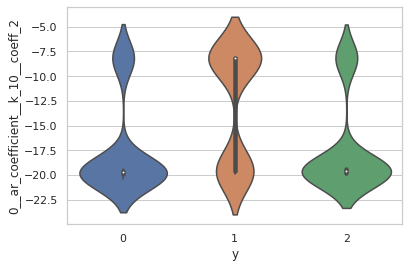

In [139]:
import seaborn as sns
df = X_0.join(y)
df['y'] = df['y'].astype('category')
sns.set(style="whitegrid")
ax = sns.violinplot(x="y", y='0__ar_coefficient__k_10__coeff_2', data=df)

In [147]:
import os

filenames = []

# get all the paths of the files to be loaded in
for root, dirs, files in os.walk('data/features/'):
    for file in files:
        if file.endswith("_eff.h5"):
            filenames.append(os.path.join(root, file))

In [148]:
filenames

['data/features/achat_0_eff.h5',
 'data/features/achat_10_eff.h5',
 'data/features/achat_11_eff.h5',
 'data/features/achat_12_eff.h5',
 'data/features/achat_13_diffs_eff.h5',
 'data/features/achat_13_eff.h5',
 'data/features/achat_14_eff.h5',
 'data/features/achat_15_eff.h5',
 'data/features/achat_16_eff.h5',
 'data/features/achat_17_eff.h5',
 'data/features/achat_18_eff.h5',
 'data/features/achat_19_eff.h5',
 'data/features/achat_1_eff.h5',
 'data/features/achat_20_eff.h5',
 'data/features/achat_21_diffs_eff.h5',
 'data/features/achat_21_eff.h5',
 'data/features/achat_22_eff.h5',
 'data/features/achat_23_eff.h5',
 'data/features/achat_24_eff.h5',
 'data/features/achat_25_eff.h5',
 'data/features/achat_26_eff.h5',
 'data/features/achat_27_eff.h5',
 'data/features/achat_28_eff.h5',
 'data/features/achat_29_eff.h5',
 'data/features/achat_2_eff.h5',
 'data/features/achat_30_diffs_eff.h5',
 'data/features/achat_30_eff.h5',
 'data/features/achat_31_eff.h5',
 'data/features/achat_32_eff.h5',

In [155]:
f = filenames[0]
os.path.split(f)


NameError: name 'X_filt' is not defined